# A tutorial for clustermargin

This notebook shows a small demonstration for clustermargin, one of the five types we can currently visualize. 
It visualizes the magin for two 2D-Clusters with the Support-Vector-Machine (SVM) and three different kernels linear/rbf/sigmoid.
We are creating an example cluster, plot several datapoints and lay a heatmap over it. 

## 1. Imports:
At first, we need to import several packages. 

In [ ]:
from typing import Literal

from matplotlib.colors import Colormap
import matplotlib.pyplot as plt
import numpy as np
from sklearn.svm import SVC

from probly.visualization.clustermargin.clustervisualizer import plot_uncertainty
import probly.visualization.config as cfg

print (
    f"Imports successfully loaded."
)

Imports successfully loaded.


## 2. A small demonstration:
We generate two reproducible 2D clusters using a fixed random seed (`value = 42`).
The cluster centers are controlled via `loc` and their spread and overlap via `scale`.

We then call `plot_uncertainty()` to visualize the samples and a heatmap derived from an SVM decision boundary.

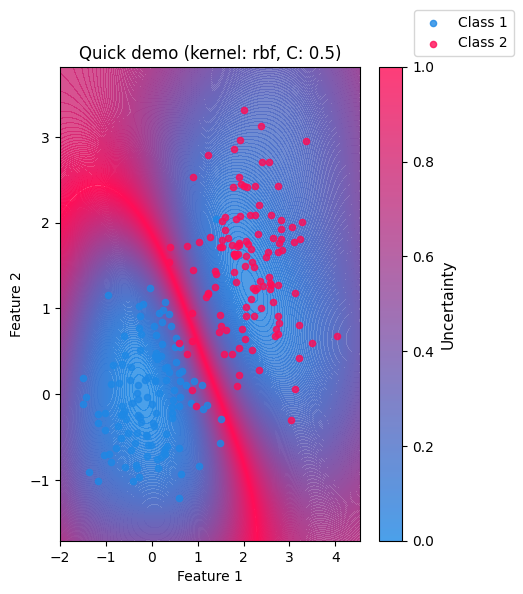

<Axes: title={'center': 'Quick demo (kernel: rbf, C: 0.5)'}, xlabel='Feature 1', ylabel='Feature 2'>

In [13]:
value = 42
rng = np.random.default_rng(value)

n1, n2 = 120, 120
cluster1 = rng.normal(loc=(0.0, 0.0), scale=0.7, size=(n1, 2))
cluster2 = rng.normal(loc=(2.0, 1.5), scale=0.7, size=(n2, 2))

plot_uncertainty(
    cluster1,
    cluster2,
    title="Quick demo",
    kernel="rbf",
    C=0.5,
    gamma="scale",
    show=True,
)

## 3. Code breakdown: What happens step-by-step


This module visualizes uncertainty between two 2D clusters using a Support Vector Machine (SVM).
The plot consists of:

the two labeled point clouds (scatter)

a background heatmap showing high uncertainty near the decision boundary and low uncertainty far away

Helper functions (private)
_check_shape(input_data: np.ndarray) -> np.ndarray

Purpose: Ensure input arrays have the expected format: a non-empty NumPy array with shape (n_samples, 2).

What it does:

Verifies the input is a np.ndarray

Rejects empty arrays

Rejects arrays that are not 2D or do not have exactly 2 columns

Why it matters:
All later computations assume 2D points (x, y). This prevents hard-to-debug runtime errors later.

_2_cluster_to_y(cluster1, cluster2) -> np.ndarray

Purpose: Build the label vector y for SVM training.

What it does:

Validates both clusters with _check_shape

Creates labels:

cluster1 → label 0

cluster2 → label 1

Concatenates into one 1D array y of length len(cluster1) + len(cluster2)

Why it matters:
SVM needs a target label for each training sample.

_2_cluster_to_x(cluster1, cluster2) -> np.ndarray

Purpose: Stack both clusters into a single feature matrix X.

What it does:

Validates both clusters

Uses np.vstack to produce one array of shape (n1 + n2, 2)

Why it matters:
SVM expects training data as one matrix X and one label vector y.

_plot_svm_beam(ax, clf, X, cmap) -> None

Purpose: Compute and draw the uncertainty heatmap based on the trained SVM.

Step-by-step:

Define plotting area

Computes min/max of x and y (with padding) from X

Create a grid over the plane

Uses np.meshgrid to sample many points (500×500)

Compute SVM margin

clf.decision_function(grid) returns the signed distance-like score to the decision boundary

margin = abs(...) makes it non-negative: 0 near boundary, larger farther away

Convert margin → uncertainty

uncertainty = exp(-margin)

near boundary: margin ≈ 0 → exp(0) = 1 (high uncertainty)

far away: margin large → exp(-large) ≈ 0 (low uncertainty)

Normalize uncertainty to [0, 1]

ensures consistent color scaling

Plot filled contours

ax.contourf(..., levels=200, cmap=cmap, alpha=0.8) draws the heatmap

Add colorbar

cfg.style_colorbar(...) formats it

Interpretation:
The “uncertainty beam” highlights the region where the classifier is least confident (close to the decision boundary).

Main function (public)
plot_uncertainty(...) -> plt.Axes

Purpose: This is the main entry point. It:

validates inputs

builds X and y

plots the data points

trains an SVM

overlays the uncertainty heatmap

returns the Axes for further customization

Step-by-step:

Axes setup

If ax is not provided, a new figure/axes is created with plt.subplots.

Prepare training data

X = _2_cluster_to_x(input_1, input_2) creates the stacked feature matrix

y = _2_cluster_to_y(input_1, input_2) creates labels (0/1)

Validate X again

X = _check_shape(X) ensures stacking preserved the expected format

Validate hyperparameters

Checks gamma:

if numeric: must be >= 0.0

if string: must be "auto" or "scale"

Checks C (regularization):

currently the code checks C < 0.0; in practice SVC requires C > 0 (so C == 0 should also be rejected if you want to be strict)

Checks label length matches sample count

Label axes and title

ax.set_xlabel, ax.set_ylabel

Title includes kernel and C:
"{title} (kernel: {kernel}, C: {C})"

Prepare legend names

Determines how many classes exist in y (normally 2)

If class_labels is not given, it generates "Class 1", "Class 2"

Scatter plot of the two clusters

Picks colors using the configured colormap cfg.PROBLY_CMAP

Loops over each class label, plots points with ax.scatter(...)

Train the SVM

clf = SVC(kernel=kernel, C=C, gamma=gamma)

clf.fit(X, y)

Place legend and adjust layout

Legend is positioned outside the plot to make room for the colorbar.

subplots_adjust(...) reserves space on the right/top.

Overlay the uncertainty heatmap

Calls _plot_svm_beam(ax, clf, X, cmap) to compute uncertainty and draw it.

Display or return

If show is True, calls plt.show()

Always returns ax so you can add more styling afterward.

### 3.2 Difference between kernels

A `kernel` defines the shape of the decision boundary by implicitly mapping the data into another feature space. <br>

**kernel="linear":**

Decision boundary is a straight line in 2D (a hyperplane in higher dimensions).

Works best when classes are approximately linearly separable.

Pros: fast, simple, stable, fewer hyperparameters.

Cons: cannot model curved boundaries.

In the plot: expect a mostly straight separating region and uncertainty band.

**kernel="rbf" (Radial Basis Function / Gaussian):**

Produces nonlinear, curved boundaries.

Great default when you expect complex shapes or overlapping clusters.

Sensitive to gamma (and also to C).

In the plot: can create curved separation with an uncertainty band that adapts to the data geometry.

**kernel="sigmoid":**

Nonlinear kernel inspired by neural networks (tanh-like behavior).

Can work, but is often less reliable than rbf unless tuned carefully.

Sensitive to scaling and hyperparameters (gamma, and also coef0 if you use it later).

In the plot: can look similar to linear in some settings, or behave oddly if parameters are not well tuned.

In [ ]:
for kernel in ["linear", "rbf", "sigmoid"]:
    ax = plot_uncertainty(
        cluster1,
        cluster2,
        title="Kernel comparison",
        kernel=kernel,
        C=0.5,
        gamma="scale",
        show=True,
    )

### 3.3 How C influences the outcome.
`C` controls the trade-off between fitting data and keeping the decision boundary smooth.

**High C:** <br>
The model penalizes misclassifications strongly, it tries hard to classify every training point correctly.<br>
Result: tighter boundary, less tolerance for outliers, **higher risk of overfitting**.

**Low C:** <br>
The model allows **more classification errors**, it prefers a simpler boundary. <br>
Result: smoother boundary, more tolerance for noise/outliers, often better generalization.

In the clustermargin plot, changing `C` often changes how “tight” the transition region between the two clusters looks.

In [ ]:
for C in [0.1, 0.5, 2.0]:
    ax = plot_uncertainty(
        cluster1,
        cluster2,
        title="Effect of C",
        kernel="rbf",
        C=C,
        gamma="scale",
        show=True,
    )

### 3.4 How gamma influences the outcome.
`gamma` mostly matters for nonlinear kernels (`rbf` and `sigmoid`). It controls how far the influence of a single training point reaches.<br>

**High gamma:**<br>
Each point influences only a very **small neighborhood**.<br>
Result: the decision boundary becomes very local and wiggly, potentially overfitting.

**Low gamma:**<br>
Each point influences a **larger region**.<br>
Result: the boundary becomes smoother and more global, potentially underfitting.

**Special options:**<br>
`gamma="scale"`: uses 1 / (n_features * X.var())<br>
`gamma="auto"`: uses 1 / n_features

In `clustermargin`, `gamma` strongly affects how “narrow” or “wide” the uncertainty band is around the boundary.

In [ ]:
for gamma in ["scale", 0.2, 1.0, 5.0]:
    ax = plot_uncertainty(
        cluster1,
        cluster2,
        title="Effect of gamma",
        kernel="rbf",
        C=0.5,
        gamma=gamma,
        show=True,
    )

### x. Further reading:
https://scikit-learn.org/stable/modules/svm.html
